# Importing Runkeeper Data

This script imports my training data from Runkeeper API.

### Step 1 - Loading required libraries

In [1]:
%matplotlib inline

In [2]:
import datetime, json, urllib2

import numpy as np
import pandas as pd

from pandas import Series, DataFrame

### Step 2 - Importing data into a Pandas DataFrame

In [3]:
url = "https://api.runkeeper.com/fitnessActivities?pageSize=300&access_token=0006f0cb9cd840d1894b0f5dbcb7c010"
data = urllib2.urlopen(url).read()
data = json.loads(data)
data = data["items"]

df = DataFrame(data) # The DataFrame containing the training raw data.

# Now let's cleaning the table. I just need three information from my exercises: distance, duration and time.

df = df[["duration", "start_time", "total_distance"]]
df.columns = ["duration", "start", "distance"]

# Let's get a look into the table

df.head()

,duration,start,distance
0,3604.0,"Sun, 15 May 2016 19:02:15",10928.923015
1,1814.0,"Sat, 14 May 2016 19:39:41",6122.570123
2,1807.0,"Thu, 12 May 2016 19:15:37",5845.589634
3,2172.0,"Tue, 10 May 2016 20:10:53",7019.550870
4,1844.0,"Tue, 3 May 2016 20:56:58",6004.454081


### Step 3 - Converting data values

In [4]:
# Converting start date string to datetime format 
def to_datetime(string):
    return datetime.datetime.strptime(string, "%a, %d %b %Y %X")

df.start = df.start.apply(to_datetime)

# Creating a useful weekday column
weekdays = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sab", "Dom"]

df["weekday"] = df.start.apply(lambda d: d.weekday()).apply(lambda w: weekdays[w])


# Now converting duration string to timedelta format
def to_timedelta(num):
    return datetime.timedelta(seconds = int(num))

raw_duration = df.duration # Will use this to calculate pace
df.duration = df.duration.apply(to_timedelta)

# And finnaly, let's round distance to meters and convert it to Km
def to_km(num):
    return int(num) / 1000.0

df.distance = df.distance.apply(to_km)

# Let's look again:

df.head()

# Seems better now :)

,duration,start,distance,weekday
0,01:00:04,2016-05-15 19:02:15,10.928,Dom
1,00:30:14,2016-05-14 19:39:41,6.122,Sab
2,00:30:07,2016-05-12 19:15:37,5.845,Qui
3,00:36:12,2016-05-10 20:10:53,7.019,Ter
4,00:30:44,2016-05-03 20:56:58,6.004,Ter


In [5]:
# Since we want analyse pace rate (min/Km) frequently, let's create another column with this data.

df["pace"] = (raw_duration / df.distance) / 60
#df.pace = df.pace.apply(to_timedelta)

df.sort_values("pace", ascending=False).head()

,duration,start,distance,weekday,pace
191,00:35:03,2014-01-28 19:53:02,3.456,Ter,10.141782
208,00:26:01,2013-12-17 19:50:23,4.110,Ter,6.330089
212,00:26:02,2013-12-10 18:24:10,4.135,Ter,6.295848
200,00:30:01,2014-01-11 18:38:07,5.029,Sab,5.968715
144,00:30:09,2014-11-16 16:25:13,5.056,Dom,5.963212


In [6]:
# Oops... there are an activity with anomalous pace (in fact I've walking a lot during this activity).
# Let's apply some filter.

df = df[df.pace < 10]

## Step 4 - Visualizing data

Let's plot all my running activities. The x axis indicates my pace (in seconds per km). The y axis indicate my total distance. Darker green dots are newer and lighter are older activities.

In [14]:
#from bokeh.charts import Scatter, output_notebook, show
from bokeh.plotting import figure, output_notebook, show

# Let's create an interactive plot with all my trainings
plot =  Scatter(df, x="start", y="distance", color="weekday", 
                title="My trainings",
                legend="top_right",
                xlabel="Average pace (min/km)",
                ylabel="Distance (km)")

plot2 = figure()
plot2.scatter(df.start, df.distance, color=df.weekday)


output_notebook()
show(plot)

Loading BokehJS ...

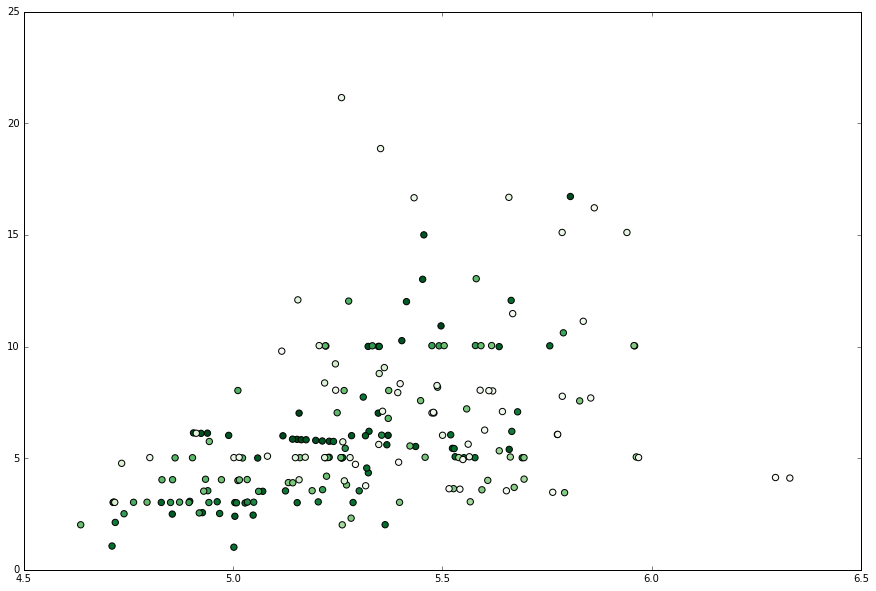

In [8]:
import matplotlib.pyplot as plt
#import seaborn; seaborn.set() #Not working anymore. Perhaps after scipy update
plt.figure(figsize=(15,10))
plt.scatter(df["pace"], df["distance"], c=df["start"], cmap=plt.cm.Greens, s=40)

In [9]:
df[df.distance > 5].sort_values("pace", ascending=True).head()

,duration,start,distance,weekday,pace
178,00:24:08,2014-02-26 20:55:09,5.027,Qua,4.800743
96,00:24:23,2015-05-05 16:09:19,5.016,Ter,4.861111
101,00:24:37,2015-04-21 20:39:54,5.021,Ter,4.902742
5,00:30:05,2016-05-01 16:57:29,6.133,Dom,4.905158
163,00:30:03,2014-04-20 17:24:21,6.118,Dom,4.911736
